<font size="10">Forecasting the Henon Map with Neural Networks</font>

<font size="4">This notebook employs a feedforward neural network architecture to forecast orbits of the [Henon map](https://en.wikipedia.org/wiki/H%C3%A9non_map) at chaotic parameter values. The loss function includes a parameter "steps" that allows one to incorprorate the sequential property of the data into the network training. That is, the loss function includes knowledge of not just stepping from one iterate to the next, but compositions of the network with itself to move a point further into the future.</font>

<font size="4">This code was written by Jason J. Bramburger and accompanies the work in Section 4.3 of the book <i>Data-Driven Methods for Dynamic Systems</i>. We use Tensorflow 2.0 to build the neural network, which is imported as tf.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Henon Map
def Henon(x,a = 1.4, b = 0.3):
    
    xnp1 = [1 - a*x[0]**2 + x[1], b*x[0]]
    
    return xnp1

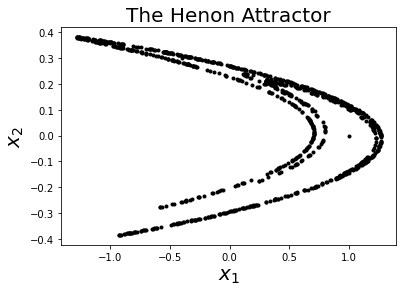

In [25]:
# Generate Henon Data

# Henon parameters
a = 1.4
b = 0.3 # Text uses b = 0.01 or b = 0.3 

# Initializations
N = 1001
x = np.zeros((N,2))
x[0] = [1, 0]

for n in range(1,N):
    x[n] = Henon(x[n-1], a, b)

# Plot Henon Trajectories
fig = plt.figure()
plt.plot(x[:,0],x[:,1],'k.') 
plt.title('The Henon Attractor', fontsize = 20)
plt.xlabel('$x_1$', fontsize = 20)
plt.ylabel('$x_2$', fontsize = 20)

# Build input data matrix of forward iterates
forward_iters = 10
xnforward = []

for j in range(forward_iters): 
    xnforward.append(x[j:-forward_iters+j])

In [4]:
def init_model(num_hidden_layers = 4, num_neurons_per_layer = 20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is 2D - each component of the Henon output
    model.add(tf.keras.Input(2))

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('relu'),
            kernel_initializer='glorot_normal'))

    # Output is 2D - next step of Henon map
    model.add(tf.keras.layers.Dense(2))
    
    return model

In [5]:
def compute_loss(model, xnforward, steps):
    
    loss = 0
    
    for s in range(steps):
        
        if s == 0:
            xpred = model(xnforward[0])
        else:
            xpred = model(xpred)
        
        xnp1 = xnforward[s+1]
        
        loss += tf.reduce_mean( tf.square( xpred - xnp1 ) )/steps

    return loss

In [6]:
def get_grad(model, xnforward, steps):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, xnforward, steps)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [7]:
# Initialize model aka tilde u
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,1e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [19]:
from time import time

steps = 4

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, xnforward, steps)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs
N = 10000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 2.43936229e-05
It 00050: loss = 2.52568152e-05
It 00100: loss = 2.21936934e-05
It 00150: loss = 2.20776728e-05
It 00200: loss = 2.19934500e-05
It 00250: loss = 2.19246904e-05
It 00300: loss = 2.18630594e-05
It 00350: loss = 2.18077366e-05
It 00400: loss = 2.17560555e-05
It 00450: loss = 2.17069355e-05
It 00500: loss = 2.16590888e-05
It 00550: loss = 2.16128210e-05
It 00600: loss = 2.15663495e-05
It 00650: loss = 2.15227119e-05
It 00700: loss = 2.14734791e-05
It 00750: loss = 2.14284264e-05
It 00800: loss = 2.13826388e-05
It 00850: loss = 2.13447056e-05
It 00900: loss = 2.13095282e-05
It 00950: loss = 2.15284963e-05
It 01000: loss = 2.14913380e-05
It 01050: loss = 2.13990061e-05
It 01100: loss = 2.13901440e-05
It 01150: loss = 2.11629067e-05
It 01200: loss = 2.11215192e-05
It 01250: loss = 2.11091101e-05
It 01300: loss = 2.09903992e-05
It 01350: loss = 2.09478458e-05
It 01400: loss = 2.09188947e-05
It 01450: loss = 2.08764977e-05
It 01500: loss = 2.08925412e-05
It 01550

Text(0, 0.5, '$x_1$')

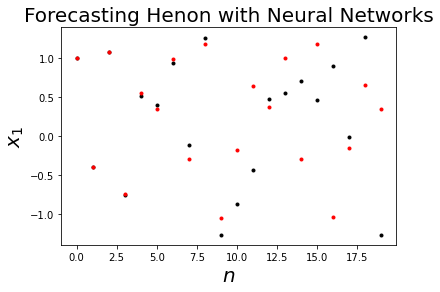

In [20]:
# Use Trained Model to Forecast
M = 101

xpred = np.zeros((M,2))
xpred[0] = x[0,:]

for m in range(1,M):
    xpred[m] = model(xpred[m-1:m,:])   
    
# Plot Henon Trajectories
fig = plt.figure()
plt.plot(xpred[:20,0],'k.') 
plt.plot(x[:20,0],'r.') 
plt.title('Forecasting Henon with Neural Networks', fontsize = 20)
plt.xlabel('$n$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20)   

In [21]:
# Save results
!mkdir -p Henon_models
model.save('Henon_models/Henon_step=4_b=0_3')

# Save data as .mat file
import scipy.io
scipy.io.savemat('Henon_step=4_b=0_3.mat', dict(xpred = xpred, xtrue = x, steps = steps))

INFO:tensorflow:Assets written to: Henon_models/Henon_step=4_b=0_3/assets


In [11]:
# Load and view saved models
#saved_model = tf.keras.models.load_model('Henon_models/Henon_step=3_b=0_01')
saved_model = tf.keras.models.load_model('Henon_models/Henon_step=3_b=0_3')
saved_model.summary()

# Check loss on training data
saved_model.compile()
loss, grad_theta = get_grad(saved_model, xnforward, steps)
print('')
print('loss on training data = ', loss.numpy())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 2)                 42        
                                                                 
Total params: 1,362
Trainable params: 1,362
Non-trainable params: 0
_________________________________________________________________

loss on training data =  4.0284067e-06
